# Installing necessary packages to run Tensorflow-Object Detetion_API in colab

**Note**: It's best if you use a gpu for this, go to edit->notebook settings and change hardware accelerator to GPU

In [0]:
!pip install tensorflow-gpu==1.15

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Get the tensorflow object detection api files

In [0]:
!git clone https://github.com/tensorflow/models.git

Install the protobuf compilers so that we can train and convert our model

In [0]:
!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

Check how much execution time you have left, max is 12h

In [0]:
import time, psutil
Start = time.time()- psutil.boot_time()
Left= 12*3600 - Start
print('Time remaining for this session is: ', Left/3600)

In [0]:
!pwd

# Model preperation

Any model exported using the **export_inference_graph.py** tool can be loaded here simply by changing **PATH_TO_FROZEN_GRAPH** to point to a new .pb file.

By default we use an "**SSD with Mobilenet**" model here. See the detection model zoo for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

+ download model

In [0]:
cd /content//models/

In [0]:
!pwd

In [0]:
!curl -O http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz

+ load model from graph

In [0]:
!tar xvzf ssd_mobilenet_v1_coco_11_06_2017.tar.gz

In [0]:
%rm -rf checkpoints
%mkdir checkpoints

In [0]:
cp ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.* checkpoints/

Download the dataset, you can put your own link or upload a zip file with your data, we have labeled our food data and have uploaded it to roboflow, an online system that takes your images and xml labels and builds a dataset, it is then able to convert it to  TFrecord, the format we will use.

If you already have the data in TFrecord formmat good, if you only have the bounding box files and images you can make your own scripts to convet them or use the same process as we did 

In [0]:
!curl -L [YOUR DATASET LINK HERE] > roboflow.zip; unzip roboflow.zip; rm roboflow.zip 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1283      0 --:--:-- --:--:-- --:--:--  1283
100 34.7M  100 34.7M    0     0  6173k      0  0:00:05  0:00:05 --:--:-- 9199k
Archive:  roboflow.zip
 extracting: test/Foods.tfrecord     
 extracting: train/Foods.tfrecord    
 extracting: test/Foods_label_map.pbtxt  
 extracting: train/Foods_label_map.pbtxt  
 extracting: README.roboflow.txt     


In [0]:
mkdir tf_record

In [0]:
!mkdir annotations
!mv train/Foods_label_map.pbtxt annotations/label_map.pbtxt

In [0]:
!mv train/Foods.tfrecord tf_record/train.record
!mv test/Foods.tfrecord tf_record/test.record

# Modify config file under models/research/object_detection/samples/configs
Check the pbtxt file to get the number of classes

In [0]:
!cp research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config .

Modify it
* We have 90 classes so change num_classes to 90
* Set fine_tune_checkpoint to checkpoints/model.ckpt
* Change:

train_input_reader: {  
  tf_record_input_reader {  
    input_path: "tf_record/train.record"  
  }  
  label_map_path: "annotations/label_map.pbtxt"  
}  
eval_input_reader: {  
  tf_record_input_reader {  
    input_path: "tf_record/test.record"  
  }  
  label_map_path: "annotations/label_map.pbtxt"  
  shuffle: false 
  num_readers: 1  
}

In [0]:
!pwd
! rm -rf train
! rm -rf test

In [0]:
# Make directory for storing training progress
!mkdir train
# Make directory for storing validation results
!mkdir eval

Begin the training process in the config file the model will run for 200K steps however since it is probable you won't have enough time you can stop the model once you reach the loss val you want (loss vals of 1 are ideal).

In [0]:
#Begin training
!python research/object_detection/legacy/train.py --logtostderr --train_dir=train --pipeline_config_path=ssd_mobilenet_v1_pets.config

In [0]:
!pwd

In [0]:
!mkdir exported
!mkdir exported/complete

Export your model to a frozen graph, pay close attention to the trained_checkpoint_prefix. The model will make checkpoints and saved the most recent ones in the train file, depending on how many steps you make you need to specify the step for the checkpoint, in our case one of the checkpoints that we found acceptable was the model.ckpt-15225* the * means that in the folder train there were more files with that prefix, when we specify the ckp step here the script will take all those necessary files for that step and exprot your model in a frozen graph in protocol buffer format

In [0]:
!python research/object_detection/export_inference_graph.py \
--input_type=image_tensor \
--pipeline_config_path=ssd_mobilenet_v1_pets.config \
--trained_checkpoint_prefix=train/model.ckpt-15225 \
--output_directory=exported/complete

In [0]:
mkdir exported/tflite

After it has exported our model into a frozen graph it can make predictions on images, however since we want to integrate the model in our FoodieShoot application we need to convert it to a Tflite format, in these format the model will perform well without consuming too much of our mobile resources.

Here we are taking that frozen graph and converting it to a tf lite frozen graph

In [0]:
!python research/object_detection/export_tflite_ssd_graph.py \
--pipeline_config_path=ssd_mobilenet_v1_pets.config \
--trained_checkpoint_prefix=train/model.ckpt-15225 \
--output_directory=exported/tflite \
--add_postprocessing_op=true

In [0]:
cp annotations/label_map.pbtxt exported

In [0]:
!pwd

After exporting the model to a tf lite frozen graph the TF object detection android api can't yet use the frozen graph and has to take that same graph and convert it to a model.tflite format, to do that we use toco, since we have processed our data and scaled it to 300x300 pxls the tflite must then use those formats. On the android api we will then scale down images to fit that size, this processe may make the prediction more difficult and slower but after testing we found 300 to be the best value for all types of mobile devices

In [0]:
!toco \
 --graph_def_file="/content/models/exported/tflite/tflite_graph.pb" \
 --output_file="/content/models/exported/tflite/detect.tflite" \
 --input_shapes=1,300,300,3 \
 --input_arrays=normalized_input_image_tensor \
 --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
 --inference_type=FLOAT \
 --allow_custom_ops

Zip and download the files, we are zipping the models folder as well for a future train if we ever want to use the checkpoints, but for android you only need the exported/lite and labels

In [0]:
%cd /content
!zip -r Models_models.zip models

In [0]:
!zip -r Models_exported.zip /content/models/exported

If you want you can test an image 

In [0]:
%cd /content
!mkdir img
%cd img
from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

In [0]:
cd /content/models/research/object_detection

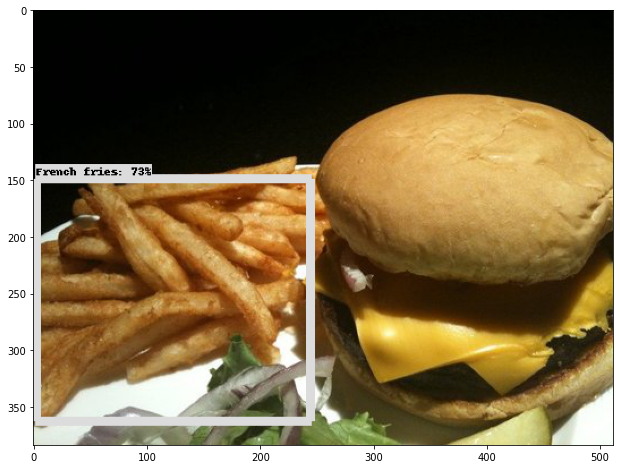

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline

from utils import label_map_util

from utils import visualization_utils as vis_util

# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/models/exported/complete/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/models/annotations', 'label_map.pbtxt')

NUM_CLASSES = 90


detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/img/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)



def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
